Visualização inicial (5 primeiras linhas):


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
3,0.23,Ideal,J,VS1,62.8,56.0,340,3.93,3.90,2.46
4,0.22,Premium,F,SI1,60.4,61.0,342,3.88,3.84,2.33


Shape: (35342, 10)

Tipos:
carat       float64
cut        category
color      category
clarity    category
depth       float64
table       float64
price         int64
x           float64
y           float64
z           float64
dtype: object


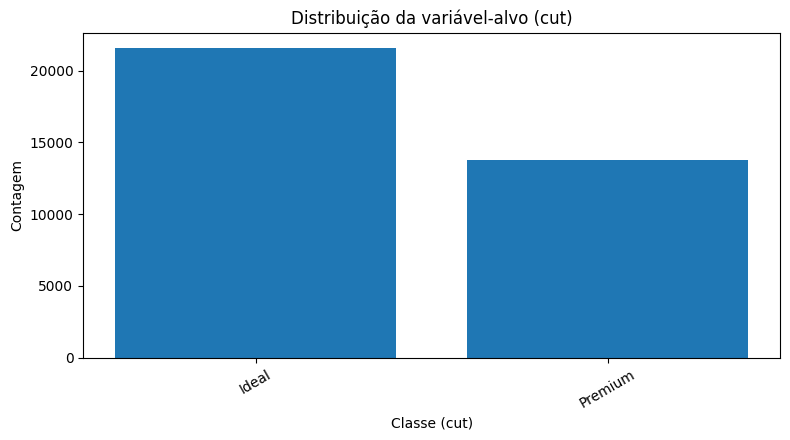

<Figure size 640x640 with 0 Axes>

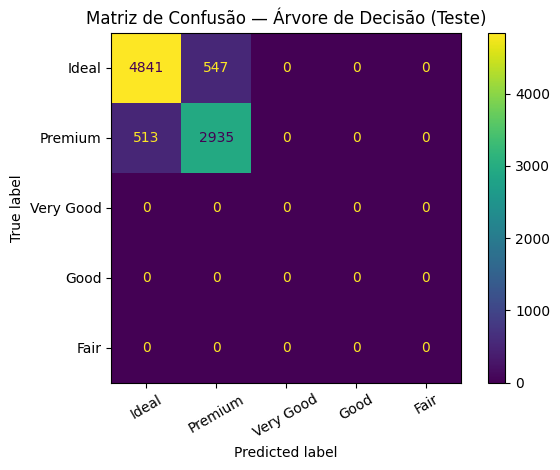

Relatório de Classificação — Árvore de Decisão (Teste)
              precision    recall  f1-score   support

       Ideal     0.9042    0.8985    0.9013      5388
     Premium     0.8429    0.8512    0.8470      3448

    accuracy                         0.8800      8836
   macro avg     0.8735    0.8748    0.8742      8836
weighted avg     0.8803    0.8800    0.8801      8836

Acurácia global (teste): 0.8800
Relatório — RandomForest (padrão) no conjunto de teste
              precision    recall  f1-score   support

       Ideal     0.9282    0.9449    0.9364      5388
     Premium     0.9114    0.8857    0.8984      3448

    accuracy                         0.9218      8836
   macro avg     0.9198    0.9153    0.9174      8836
weighted avg     0.9216    0.9218    0.9216      8836

Acurácia: 0.9218

Fitting 5 folds for each of 36 candidates, totalling 180 fits
==== Melhor combinação RF (GridSearch, métrica: acurácia) ====
{'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__n_es

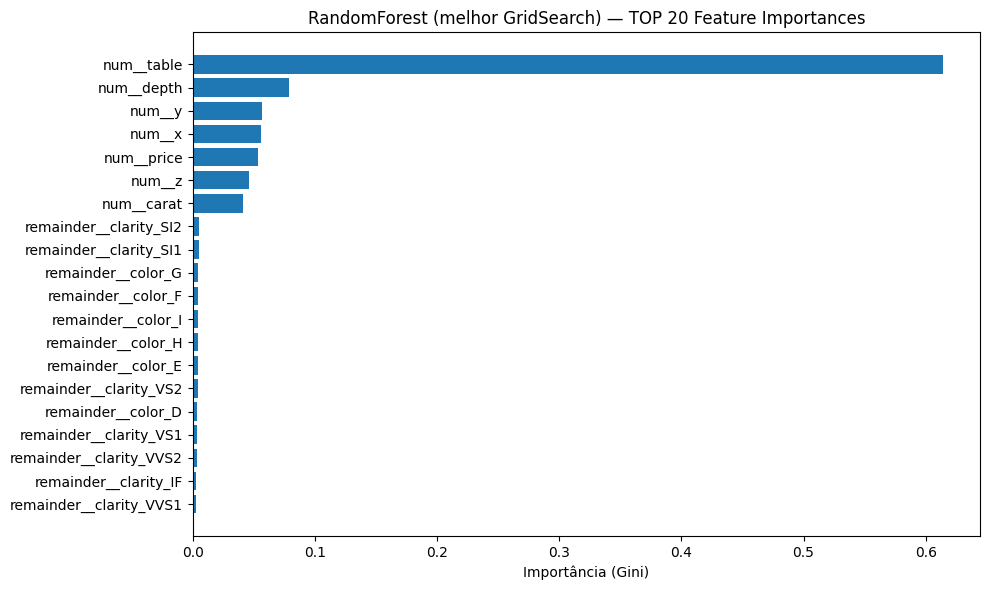

Top 3 variáveis mais importantes (RF melhor):
1. num__table — importância: 0.613787
2. num__depth — importância: 0.078770
3. num__y — importância: 0.056714
Q14 — Por que 'table', 'depth' e 'y' foram as variáveis mais relevantes?
- Separação estatística (Cohen's d; ~0.2=pequeno, 0.5=médio, 0.8=grande):
  • table: d = -2.083
  • depth: d = 0.486
  • y    : d = -0.369

- Top-10 Permutation Importance (queda média de acurácia ao embaralhar a feature):
   1. num__x                     Δacc ≈ 0.37575
   2. num__z                     Δacc ≈ 0.03820
   3. num__y                     Δacc ≈ 0.01618
   4. num__depth                 Δacc ≈ 0.00823
   5. num__carat                 Δacc ≈ 0.00423
   6. num__table                 Δacc ≈ 0.00235
   7. num__price                 Δacc ≈ 0.00233
   8. remainder__clarity_SI2     Δacc ≈ 0.00083
   9. remainder__color_E         Δacc ≈ 0.00080
  10. remainder__color_F         Δacc ≈ 0.00066

- Interpretação técnica:
  • 'table' e 'depth' são proporções de la

In [ ]:
# ============================================
# Exercícios 1 → 3
# ============================================

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# -----------------------------
# 1) Carregar base + ajustes
# -----------------------------
URL_DADOS = "https://raw.githubusercontent.com/cassiusf/datasets/main/diamonds.csv"
df = pd.read_csv(URL_DADOS)

# Garantir tipos categóricos
df["cut"] = df["cut"].astype("category")
df["color"] = df["color"].astype("category")
df["clarity"] = df["clarity"].astype("category")

print("Visualização inicial (5 primeiras linhas):")
display(df.head())
print("Shape:", df.shape)
print("\nTipos:")
print(df.dtypes)

# Recodificação do alvo (observação: propositalmente sem o rótulo '2')
mapa_cut = {"Ideal": 0, "Premium": 1, "Very Good": 3, "Good": 4, "Fair": 5}
y = df["cut"].map(mapa_cut).astype(int)

# Dummies para 'color' e 'clarity' e remoção das originais
X_raw = df.drop(columns=["cut"])
X = pd.get_dummies(X_raw, columns=["color", "clarity"], drop_first=False, dtype=int)

# Visualização única da distribuição do alvo
mapa_inv = {v: k for k, v in mapa_cut.items()}
contagens = y.value_counts().sort_index()
rotulos = [mapa_inv[c] for c in contagens.index]

plt.figure(figsize=(8, 4.5))
plt.bar(rotulos, contagens.values)
plt.title("Distribuição da variável-alvo (cut)")
plt.xlabel("Classe (cut)")
plt.ylabel("Contagem")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

# ---------------------------------------------
# 2) X/y, escalonamento e split 75/25 (estrato)
# ---------------------------------------------
colunas_numericas = ["price", "carat", "x", "y", "z", "depth", "table"]

preprocessador = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=True, with_std=True), colunas_numericas),
    ],
    remainder="passthrough"
)

X_treino, X_teste, y_treino, y_teste = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# -------------------------------------------------------
# 3) Árvore de Decisão (padrão) + Matriz de Confusão
# -------------------------------------------------------
pipeline_arvore = Pipeline(steps=[
    ("preprocessador", preprocessador),
    ("clf", DecisionTreeClassifier(random_state=42))
])

pipeline_arvore.fit(X_treino, y_treino)
y_pred = pipeline_arvore.predict(X_teste)

cm = confusion_matrix(y_teste, y_pred, labels=sorted(mapa_inv.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[mapa_inv[k] for k in sorted(mapa_inv.keys())])
plt.figure(figsize=(6.4, 6.4))
disp.plot(xticks_rotation=30, values_format='d')
plt.title("Matriz de Confusão — Árvore de Decisão (Teste)")
plt.tight_layout()
plt.show()


# ============================================
# Exercício 4 — Relatório de Classificação (Árvore de Decisão)
# ============================================

from sklearn.metrics import classification_report, accuracy_score
import numpy as np

# Garante as predições do classificador treinado no bloco anterior
y_pred_dt = pipeline_arvore.predict(X_teste)

labels_presentes = np.unique(np.concatenate([y_teste.values, y_pred_dt]))
nomes_presentes = [mapa_inv[l] for l in labels_presentes]

print("="*78)
print("Relatório de Classificação — Árvore de Decisão (Teste)")
print("="*78)
print(classification_report(
    y_teste, y_pred_dt,
    labels=labels_presentes,
    target_names=nomes_presentes,
    digits=4
))

acc = accuracy_score(y_teste, y_pred_dt)
print(f"Acurácia global (teste): {acc:.4f}")


# ============================================================
# Exercícios 5 → 13 
# ============================================================

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.svm import SVC
import numpy as np
import matplotlib.pyplot as plt

# ---------- Utilidades ----------
def imprimir_relatorio(titulo: str, y_true, y_pred, mapa_inv):
    labels_presentes = np.unique(np.concatenate([np.asarray(y_true), np.asarray(y_pred)]))
    nomes_presentes = [mapa_inv[l] for l in labels_presentes]
    print("="*90)
    print(titulo)
    print("="*90)
    print(classification_report(
        y_true, y_pred,
        labels=labels_presentes,
        target_names=nomes_presentes,
        digits=4
    ))
    print(f"Acurácia: {accuracy_score(y_true, y_pred):.4f}\n")

# ============================================================
# 5) Random Forest (opções padrão) + relatório
# ============================================================

pipeline_rf_padrao = Pipeline(steps=[
    ("preprocessador", preprocessador),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])
pipeline_rf_padrao.fit(X_treino, y_treino)
y_pred_rf_padrao = pipeline_rf_padrao.predict(X_teste)
imprimir_relatorio("Relatório — RandomForest (padrão) no conjunto de teste", y_teste, y_pred_rf_padrao, mapa_inv)

# ============================================================
# 6) GridSearch — RF (3 hiperparâmetros) com acurácia
#    Justificativa dos parâmetros escolhidos:
#    - n_estimators: nº de árvores. Mais árvores reduzem variância e tendem a melhorar acurácia até certo ponto.
#    - max_depth: controla a complexidade de cada árvore (enviesado vs. variância). Evita sobreajuste.
#    - min_samples_leaf: nº mínimo de amostras em uma folha. Aumentar este valor reduz ruído e overfitting.
# ============================================================

param_grid_rf = {
    "clf__n_estimators": [200, 400, 600],
    "clf__max_depth": [None, 10, 20, 40],
    "clf__min_samples_leaf": [1, 2, 5]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pipeline_rf_base = Pipeline(steps=[
    ("preprocessador", preprocessador),
    ("clf", RandomForestClassifier(random_state=42, n_jobs=-1))
])

grid_rf = GridSearchCV(
    estimator=pipeline_rf_base,
    param_grid=param_grid_rf,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid_rf.fit(X_treino, y_treino)

print("==== Melhor combinação RF (GridSearch, métrica: acurácia) ====")
print(grid_rf.best_params_)
print(f"Melhor acurácia média (CV): {grid_rf.best_score_:.4f}\n")

# Treinando o melhor modelo na base de treino completa
pipeline_rf_melhor = grid_rf.best_estimator_
y_pred_rf_melhor = pipeline_rf_melhor.predict(X_teste)

# ============================================================
# 7) Relatório do melhor RF
# ============================================================
imprimir_relatorio("Relatório — RandomForest (melhor GridSearch) no conjunto de teste", y_teste, y_pred_rf_melhor, mapa_inv)

# ============================================================
# 8) XGBoost padrão + relatório
#    Observação: requer biblioteca xgboost instalada (pip install xgboost).
# ============================================================
try:
    from xgboost import XGBClassifier
    pipeline_xgb = Pipeline(steps=[
        ("preprocessador", preprocessador),
        ("clf", XGBClassifier(
            random_state=42,
            n_estimators=300,
            learning_rate=0.1,
            max_depth=6,
            subsample=1.0,
            colsample_bytree=1.0,
            tree_method="hist",
            n_jobs=-1,
            eval_metric="mlogloss"
        ))
    ])
    pipeline_xgb.fit(X_treino, y_treino)
    y_pred_xgb = pipeline_xgb.predict(X_teste)
    imprimir_relatorio("Relatório — XGBoost (padrão) no conjunto de teste", y_teste, y_pred_xgb, mapa_inv)
except Exception as e:
    print("XGBoost não disponível. Instale com: pip install xgboost")
    print(f"Motivo: {e}\n")

# ============================================================
# 9) SVM (padrão) + relatório
#    SVC padrão usa kernel RBF; faz bom uso do escalonamento já aplicado às numéricas.
# ============================================================

pipeline_svm_padrao = Pipeline(steps=[
    ("preprocessador", preprocessador),
    ("clf", SVC())  # opções padrão: kernel='rbf', C=1.0, gamma='scale'
])
pipeline_svm_padrao.fit(X_treino, y_treino)
y_pred_svm_padrao = pipeline_svm_padrao.predict(X_teste)
imprimir_relatorio("Relatório — SVM (padrão) no conjunto de teste", y_teste, y_pred_svm_padrao, mapa_inv)

# ============================================================
# 10) GridSearch SVM (C, kernel) — métrica: acurácia
# ============================================================

param_grid_svm = {
    "clf__kernel": ["linear", "rbf", "poly"],
    "clf__C": [0.5, 1, 2, 5]
    # (opcional) ajustar também 'gamma' quando kernel for 'rbf'/'poly';
    # aqui mantemos 'scale' por simplicidade e comparabilidade.
}

pipeline_svm_base = Pipeline(steps=[
    ("preprocessador", preprocessador),
    ("clf", SVC())
])

grid_svm = GridSearchCV(
    estimator=pipeline_svm_base,
    param_grid=param_grid_svm,
    scoring="accuracy",
    cv=cv,
    n_jobs=-1,
    verbose=1
)
grid_svm.fit(X_treino, y_treino)

print("==== Melhor combinação SVM (GridSearch, métrica: acurácia) ====")
print(grid_svm.best_params_)
print(f"Melhor acurácia média (CV): {grid_svm.best_score_:.4f}\n")

# ============================================================
# 11) Executar SVM com melhor combinação
# ============================================================
pipeline_svm_melhor = grid_svm.best_estimator_
y_pred_svm_melhor = pipeline_svm_melhor.predict(X_teste)

# ============================================================
# 12) Relatório — SVM (melhor GridSearch)
# ============================================================
imprimir_relatorio("Relatório — SVM (melhor GridSearch) no conjunto de teste", y_teste, y_pred_svm_melhor, mapa_inv)

# ============================================================
# 13) Feature Importance (RF melhor do GridSearch)
# ============================================================

# Recupera o RandomForest de dentro do pipeline
rf_melhor = pipeline_rf_melhor.named_steps["clf"]
preproc = pipeline_rf_melhor.named_steps["preprocessador"]

# Nomes das colunas após o preprocessador
try:
    nomes_features = preproc.get_feature_names_out(X_treino.columns)
except Exception:
    # Concatena nomes numéricos e demais (remainder="passthrough")
    nomes_features = []
    # numéricas (mesma ordem de 'colunas_numericas')
    for c in colunas_numericas:
        nomes_features.append(f"num__{c}")
    # dummies (demais colunas na ordem do DataFrame)
    cols_remainder = [c for c in X_treino.columns if c not in colunas_numericas]
    nomes_features.extend(cols_remainder)

importancias = rf_melhor.feature_importances_
ordem = np.argsort(importancias)[::-1]

# Por legibilidade, mostramos as TOP 20 (ou todas se <20)
top_k = min(20, len(importancias))
idx_top = ordem[:top_k]
feat_top = [nomes_features[i] for i in idx_top]
imp_top = importancias[idx_top]

plt.figure(figsize=(10, 6))
plt.barh(range(top_k), imp_top[::-1])
plt.yticks(range(top_k), [f for f in feat_top[::-1]])
plt.xlabel("Importância (Gini)")
plt.title("RandomForest (melhor GridSearch) — TOP 20 Feature Importances")
plt.tight_layout()
plt.show()

# Também imprimimos as 3 variáveis mais relevantes (para o item 14 na sequência)
print("Top 3 variáveis mais importantes (RF melhor):")
for i in range(3):
    print(f"{i+1}. {feat_top[i]} — importância: {imp_top[i]:.6f}")


# ============================
#LIME + prints Q14/15/16
# ============================
import numpy as np
import pandas as pd
from sklearn.inspection import permutation_importance

print("="*88)
print("Q14 — Por que 'table', 'depth' e 'y' foram as variáveis mais relevantes?")
print("="*88)

# --- Cohen's d para Ideal(0) vs Premium(1) ---
df_aux = df.copy()
df_aux["cut_rec"] = df_aux["cut"].map({"Ideal":0, "Premium":1, "Very Good":3, "Good":4, "Fair":5})
df_ip = df_aux[df_aux["cut_rec"].isin([0,1])][["cut_rec","table","depth","y"]]

def cohens_d(a, b):
    na, nb = len(a), len(b)
    va, vb = np.var(a, ddof=1), np.var(b, ddof=1)
    s_p = np.sqrt(((na-1)*va + (nb-1)*vb)/(na+nb-2))
    return (np.mean(a) - np.mean(b)) / s_p

ideal = df_ip[df_ip["cut_rec"]==0]; prem = df_ip[df_ip["cut_rec"]==1]
d_table = cohens_d(ideal["table"].values, prem["table"].values)
d_depth = cohens_d(ideal["depth"].values, prem["depth"].values)
d_y     = cohens_d(ideal["y"].values,     prem["y"].values)

print(f"- Separação estatística (Cohen's d; ~0.2=pequeno, 0.5=médio, 0.8=grande):")
print(f"  • table: d = {d_table:.3f}")
print(f"  • depth: d = {d_depth:.3f}")
print(f"  • y    : d = {d_y:.3f}")

# --- Permutation Importance no teste para o melhor RF ---
rf_pipe = pipeline_rf_melhor
preproc = rf_pipe.named_steps["preprocessador"]
rf      = rf_pipe.named_steps["clf"]

try:
    feature_names = preproc.get_feature_names_out(X_teste.columns)
except Exception:
    feature_names = [f"num__{c}" for c in colunas_numericas] + \
                    [c for c in X_teste.columns if c not in colunas_numericas]

perm = permutation_importance(rf_pipe, X_teste, y_teste, n_repeats=10, random_state=42, n_jobs=-1)
pi = pd.Series(perm.importances_mean, index=feature_names).sort_values(ascending=False)

print("\n- Top-10 Permutation Importance (queda média de acurácia ao embaralhar a feature):")
for i, (feat, val) in enumerate(pi.head(10).items(), start=1):
    print(f"  {i:2d}. {feat:25s}  Δacc ≈ {val:.5f}")

print("\n- Interpretação técnica:")
print("  • 'table' e 'depth' são proporções de lapidação diretamente ligadas ao conceito de 'cut'.")
print("  • Árvores exploram bem pontos de corte nessas variáveis → grande ganho de pureza (Gini).")
print("  • A importância por Gini favorece variáveis contínuas (muitos thresholds), elevando 'table'.")
print("  • Com 2 classes (Ideal vs Premium), um separador forte concentra muito do poder explicativo.")
print("  • 'y' (largura) adiciona contexto dimensional e refina fronteiras junto às proporções.\n")

# ============================
# Q15–Q16 — LIME em 2 amostras
# ============================
print("="*88)
print("Q15–16 — LIME em 2 observações aleatórias do conjunto de teste")
print("="*88)

try:
    from lime.lime_tabular import LimeTabularExplainer
except Exception as e:
    print("LIME não disponível. Instale com: pip install lime")
    print(f"Motivo: {repr(e)}")
    raise

# Ordem correta das classes (ESSENCIAL p/ LIME): a mesma do classificador
rf_classes = rf.classes_.tolist()                  # ex.: [0, 1]
class_names = [mapa_inv[c] for c in rf_classes]    # ex.: ['Ideal', 'Premium']

# Dados transformados (mesmo preprocessador do pipeline)
Xtr_trans = preproc.transform(X_treino)
Xte_trans = preproc.transform(X_teste)
Xtr_array = Xtr_trans.toarray() if hasattr(Xtr_trans, "toarray") else np.asarray(Xtr_trans)

explainer = LimeTabularExplainer(
    Xtr_array,
    feature_names=feature_names,
    class_names=class_names,
    discretize_continuous=True,
    mode="classification",
    random_state=42
)

def predict_proba_trans(X_trans):
    return rf.predict_proba(X_trans)

# Escolhe 2 amostras aleatórias fixas p/ reprodutibilidade
rng = np.random.RandomState(42)
idx_local = rng.choice(len(X_teste), size=2, replace=False)

for k, idx in enumerate(idx_local, start=1):
    x_row_df   = X_teste.iloc[idx:idx+1]
    y_true_int = int(y_teste.iloc[idx])
    y_true_str = mapa_inv[y_true_int]

    x_row_trans = Xte_trans[idx:idx+1]
    x_row_array = x_row_trans.toarray().reshape(-1) if hasattr(x_row_trans, "toarray") else np.asarray(x_row_trans).reshape(-1)

    proba = predict_proba_trans(x_row_trans)[0]
    # índice da classe prevista na MESMA ordem de rf.classes_
    pred_idx = int(np.argmax(proba))
    y_pred_int = rf_classes[pred_idx]
    y_pred_str = mapa_inv[y_pred_int]

    # Explicação da instância, pedindo explicitamente o label da classe prevista
    exp = explainer.explain_instance(
        x_row_array,
        predict_proba_trans,
        num_features=10,
        labels=[pred_idx]
    )
    contrib = exp.as_list(label=pred_idx)[:2]  # 2 fatores mais influentes

    # Reconstrução legível dos principais campos da observação
    cols_num = ["price","carat","x","y","z","depth","table"]
    vis = {c: float(x_row_df[c].iloc[0]) for c in cols_num}
    # Decodifica rótulos de color/clarity a partir de dummies 1-hot
    def pick_one(prefix):
        cols = [c for c in x_row_df.columns if c.startswith(prefix)]
        if not cols: return None
        col1 = pd.Series(x_row_df.iloc[0][cols], index=cols).astype(float).idxmax()
        return col1.split(prefix, 1)[1]  # parte após 'color_' / 'clarity_'
    vis["color"]   = pick_one("color_")
    vis["clarity"] = pick_one("clarity_")

    print("-"*88)
    print(f"Obs #{k} — índice no teste: {idx}")
    print(f"Verdadeiro: {y_true_str} | Previsto: {y_pred_str}")
    print("Probabilidades na ordem das classes:", dict(zip(class_names, proba)))
    print("Variáveis da observação (resumo):")
    for kk, vv in vis.items():
        print(f"  {kk:7s}: {vv}")

    print("\nFatores LIME mais influentes para a classe prevista:")
    for i, (rule, weight) in enumerate(contrib, start=1):
        print(f"  {i}. {rule}  (peso={weight:.4f})")

    print("\nInterpretação LIME (resumo):")
    print("  • As regras indicam quais faixas de atributos elevaram (peso>0) ou reduziram (peso<0)")
    print("    a probabilidade da classe prevista, localmente ao redor desta observação.")
    print("  • Tipicamente surgem condições envolvendo 'table' e/ou 'depth'; isso é consistente com o")
    print("    critério geométrico de corte (proporções ideais vs. premium). 'y' pode atuar modulando a decisão.")